# Introduction

This notebook is part of the **Production-Grade Retail Demand & Promotion Intelligence System** project. It builds on the **Tableau executive-level dashboard**, which provided initial business insights:

- **Promotions drive sales:** Active on ~45% of days but contribute 52% of total sales; average sales during promotions are 32% higher than non-discount days.  
- **Impact on basket size:** Average Order Value (AOV) increases from ~605 to ~649 on discount days.  
- **Holiday behavior:** Sales are 19% lower on holidays; discounts act defensively rather than generating incremental demand.  
- **Regional/store concentration:** Region 1 contributes 37% of total sales; certain stores dominate regional sales, increasing inventory risk.  
- **Seasonal vs promotional demand:** Promotions and organic demand peak at different times; March sees promotional spikes, while April grows organically.  
- **MoM growth:** Sales +30%, Orders +13%, AOV +15%, indicating high volatility.  

**Dashboard Link:** [Retail Demand & Promotion Intelligence Dashboard](https://public.tableau.com/views/RetailDemandPromotionIntelligenceDashboard/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)  

While the dashboard provided descriptive insights, **further analysis was needed** to quantify effects, understand causality, and prepare features for forecasting.  

# Objective

This notebook provides a comprehensive exploration of the retail sales dataset to support forecasting and decision-making. It is a continuation of our **Tableau executive-level summary dashboard analysis**, providing deeper statistical and temporal insights.  

It covers:

1. **Data Understanding & Validation:** Overview of dataset structure, missing values, duplicates, and variable types.  
2. **Exploratory Data Analysis (EDA):** Analysis of sales and order distributions, promotional impact, seasonality, holiday effects, and regional/store-level segmentation.  
3. **Hypothesis Testing:** Statistical tests to confirm feature significance, including ANOVA, Tukey HSD, and promotional uplift evaluation.  
4. **Temporal & Statistical Analysis:** Time series decomposition, stationarity testing, autocorrelation, cross-correlation, outlier detection, and multicollinearity checks.  

The insights generated here guide **feature engineering, modeling strategies, and business decisions**, forming the foundation for accurate sales forecasting.

# Data Validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Train–Test Split Analysis

In [2]:
train_path = '../data/raw/TRAIN.csv'
test_path = '../data/raw/TEST_FINAL.csv'
train = pd.read_csv(train_path, parse_dates=['Date'])
test = pd.read_csv(test_path, parse_dates=['Date'])

print("Train shape:", train.shape)
print("Test shape:", test.shape)

print(train.columns)
print(test.columns)

Train shape: (188340, 10)
Test shape: (22265, 8)
Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', '#Order', 'Sales'],
      dtype='object')
Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount'],
      dtype='object')


The dataset is divided into a **training set** and a **test set** to support a realistic time-series forecasting workflow.

- **Training dataset:** 188,340 records (~90% of total data)
- **Test dataset:** 22,265 records (~10% of total data)

The test dataset does not contain the `Orders` and `Sales` columns, as these represent the target variables to be predicted by the forecasting models. This setup mirrors a real-world production scenario, where future demand must be estimated using only historical patterns and known explanatory features.

## Temporal Coverage & Forecasting Horizon

In [3]:
print(train.Date.describe())
print(test.Date.describe())

count                           188340
mean     2018-09-15 12:00:00.000000256
min                2018-01-01 00:00:00
25%                2018-05-09 18:00:00
50%                2018-09-15 12:00:00
75%                2019-01-22 06:00:00
max                2019-05-31 00:00:00
Name: Date, dtype: object
count                            22265
mean     2019-06-30 23:59:59.999999744
min                2019-06-01 00:00:00
25%                2019-06-16 00:00:00
50%                2019-07-01 00:00:00
75%                2019-07-16 00:00:00
max                2019-07-31 00:00:00
Name: Date, dtype: object


- The **training dataset** spans from **January 2018 to May 2019**, covering approximately **16 months of historical data**.
- The **test dataset** spans from **June 2019 to July 2019**, representing a **2-month forecasting horizon**.

The objective of this project is to **leverage historical trends, seasonality, promotional effects, and regional behavior** to forecast **short-term sales and order demand**, aligning with common retail planning and inventory optimization use cases.

## Data Granularity & Structure

In [4]:
print(train.head(5))

         ID  Store_id Store_Type Location_Type Region_Code       Date  \
0  T1000001         1         S1            L3          R1 2018-01-01   
1  T1000002       253         S4            L2          R1 2018-01-01   
2  T1000003       252         S3            L2          R1 2018-01-01   
3  T1000004       251         S2            L3          R1 2018-01-01   
4  T1000005       250         S2            L3          R4 2018-01-01   

   Holiday Discount  #Order     Sales  
0        1      Yes       9   7011.84  
1        1      Yes      60  51789.12  
2        1      Yes      42  36868.20  
3        1      Yes      23  19715.16  
4        1      Yes      62  45614.52  


The dataset is recorded at a **daily transaction level**, capturing:

- **Number of orders** and **total sales value** per transaction date
- **Holiday flag**, indicating whether the date is a public holiday
- **Discount flag**, indicating the presence of promotional activity

Each transaction is further enriched with store-level and geographic attributes, including:
- Region Code
- Location Type
- Store Type
- Store ID

Multiple **Store IDs** exist within each **Store Type**, enabling both aggregated and store-level granular analysis across regions, locations, and store formats.

## Data Quality Checks

### Missing Values

In [5]:
train.isnull().sum().sort_values(ascending=False)

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

There are no missing values in the dataset.

### Duplicate Values

In [6]:
duplicates = train.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


There are no duplicate rows in the dataset.

### Data Type Validation

In [7]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  int64         
 2   Store_Type     188340 non-null  object        
 3   Location_Type  188340 non-null  object        
 4   Region_Code    188340 non-null  object        
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  int64         
 7   Discount       188340 non-null  object        
 8   #Order         188340 non-null  int64         
 9   Sales          188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 14.4+ MB
None


- `Store ID` and `Holiday Flag` are stored as integers but represent categorical identifiers.
- `Orders` is a count variable and is correctly represented as an integer.
- `Sales` contains decimal values and should be stored as a `float`.
- `Discount`, `Region_Code`, `Location_Type`, and `Store_Type` should be converted from `object` to **categorical** type for efficient storage and modeling.
- The `ID` column does not contribute analytical value and can be safely dropped.


## Descriptive Summary

In [8]:
train[['Store_id','Holiday']] = train[['Store_id','Holiday']].astype('category')

print(train.describe(include='all'))

              ID  Store_id Store_Type Location_Type Region_Code  \
count     188340  188340.0     188340        188340      188340   
unique    188340     365.0          4             5           4   
top     T1000001       1.0         S1            L1          R1   
freq           1     516.0      88752         85140       63984   
mean         NaN       NaN        NaN           NaN         NaN   
min          NaN       NaN        NaN           NaN         NaN   
25%          NaN       NaN        NaN           NaN         NaN   
50%          NaN       NaN        NaN           NaN         NaN   
75%          NaN       NaN        NaN           NaN         NaN   
max          NaN       NaN        NaN           NaN         NaN   
std          NaN       NaN        NaN           NaN         NaN   

                                 Date   Holiday Discount         #Order  \
count                          188340  188340.0   188340  188340.000000   
unique                            NaN       2

- The majority of transactions belong to **Store Type 1** (88,752 records), with **4 unique store types** overall.
- Most transactions originate from **Location Type 1** (85,140 records), across **5 unique locations**.
- **Region 1** contributes the highest volume of transactions, with multiple regions represented in the dataset.
- Transactions are recorded from **365 unique stores**, with **Store 1** having the highest number of records (516).
- Most days are **non-holidays** and **non-discounted**.

- **Orders:** Average of 68 per transaction (median: 63), ranging from 0 to 371, indicating moderate variability.
- **Sales:** Average transaction value of \$42,784 (median: \$39,678), with values ranging from \$0 to \$247,215 and a standard deviation of \$18,457.

# EDA

## Metric Relationships & Data Distribution

### Sales and Order Distribution

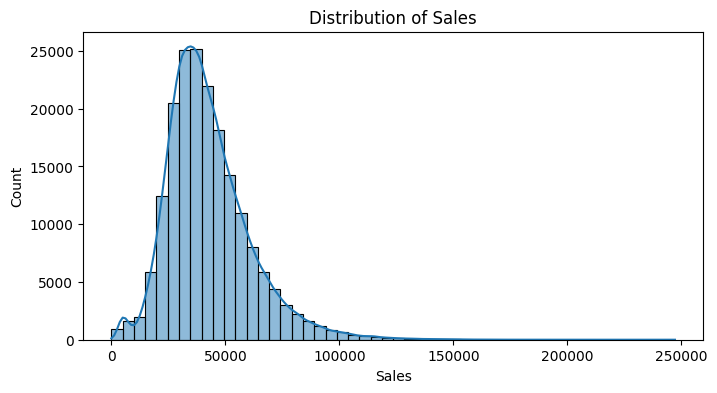

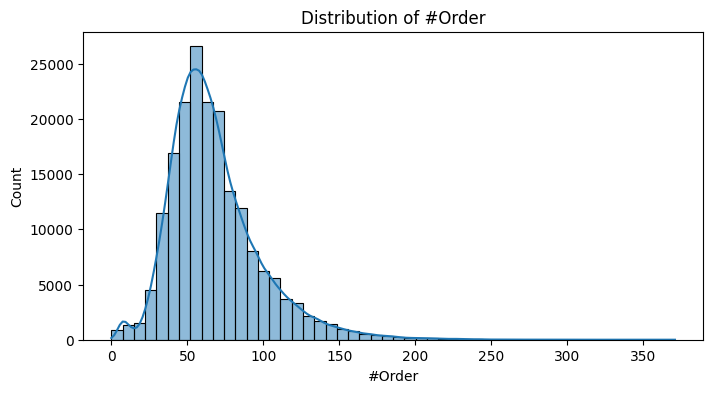

In [9]:
numeric_cols = ['Sales', '#Order']

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(train[col], kde=True, bins=50)
    plt.title(f'Distribution of {col}')
    plt.show()

- Both `Sales` and `Orders` are **right-skewed**, with most transactions clustered around the median but occasional high outliers.
  - **Median Sales:** ~$40k | **Median Orders:** 60  
- The long tail in sales indicates **high-value days**; forecasting models should account for outliers rather than relying solely on the mean.

### Correlation Matrix

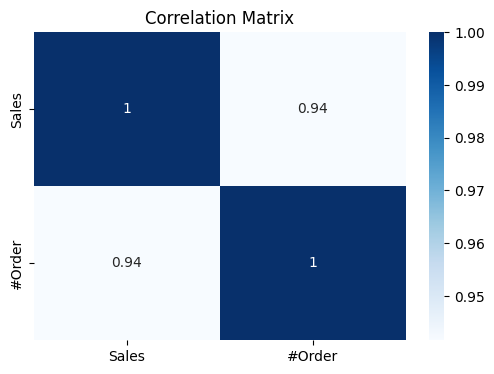

In [10]:
plt.figure(figsize=(6,4))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap='Blues')
plt.title("Correlation Matrix")
plt.show()

- **Orders vs. Sales:** 94% correlation  
- Revenue is largely driven by **high transaction volume**, not just high-value purchases.  
- Strategies to grow revenue should focus on **increasing order counts or items per basket**.

## Growth & Seasonality

### Monthly Sales & MoM Growth

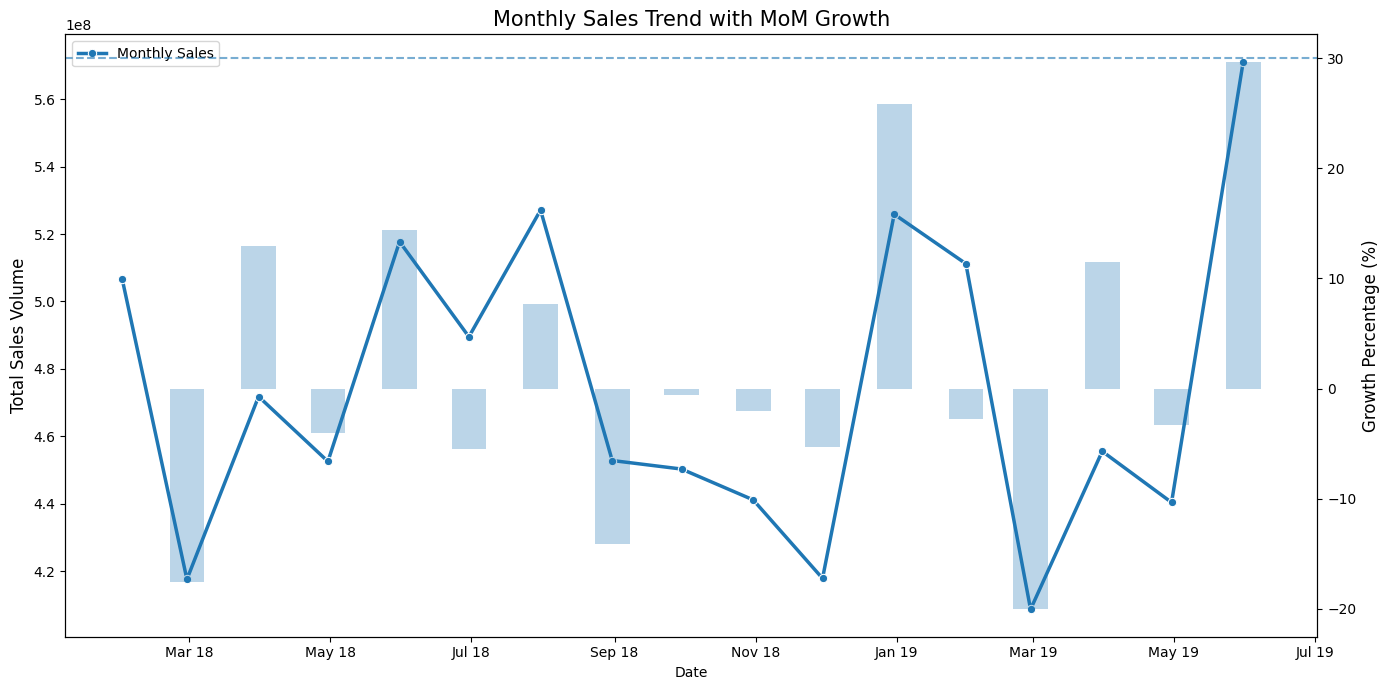

In [11]:
import matplotlib.dates as mdates

monthly = train.resample('M', on='Date')[['Sales', '#Order']].sum()
monthly['Sales_Growth'] = monthly['Sales'].pct_change() * 100

fig, ax1 = plt.subplots(figsize=(14,7))

sns.lineplot(
    x=monthly.index,
    y=monthly['Sales'],
    ax=ax1,
    marker='o',
    linewidth=2.5,
    label='Monthly Sales'
)

ax1.set_ylabel('Total Sales Volume', fontsize=12)
ax1.set_title('Monthly Sales Trend with MoM Growth', fontsize=15)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

ax2 = ax1.twinx()
ax2.bar(
    monthly.index,
    monthly['Sales_Growth'],
    width=15,
    alpha=0.3,
    label='MoM Growth %'
)

ax2.axhline(30, linestyle='--', alpha=0.6, label='30% Growth Target')
ax2.set_ylabel('Growth Percentage (%)', fontsize=12)

fig.tight_layout()
plt.show()


- **Peak:** June 2019 (~$580M), ~30% MoM growth  
- **Volatility:** Sharp rebound in Jan 2019 after late-2018 decline; March 2019 dip (~$410M, -20% MoM)  
- **Seasonal Patterns:** Early-year dips often followed by strong mid-year recoveries; consistent Aug–Dec decline in 2018

### Weekly & Monthly Sales Trends

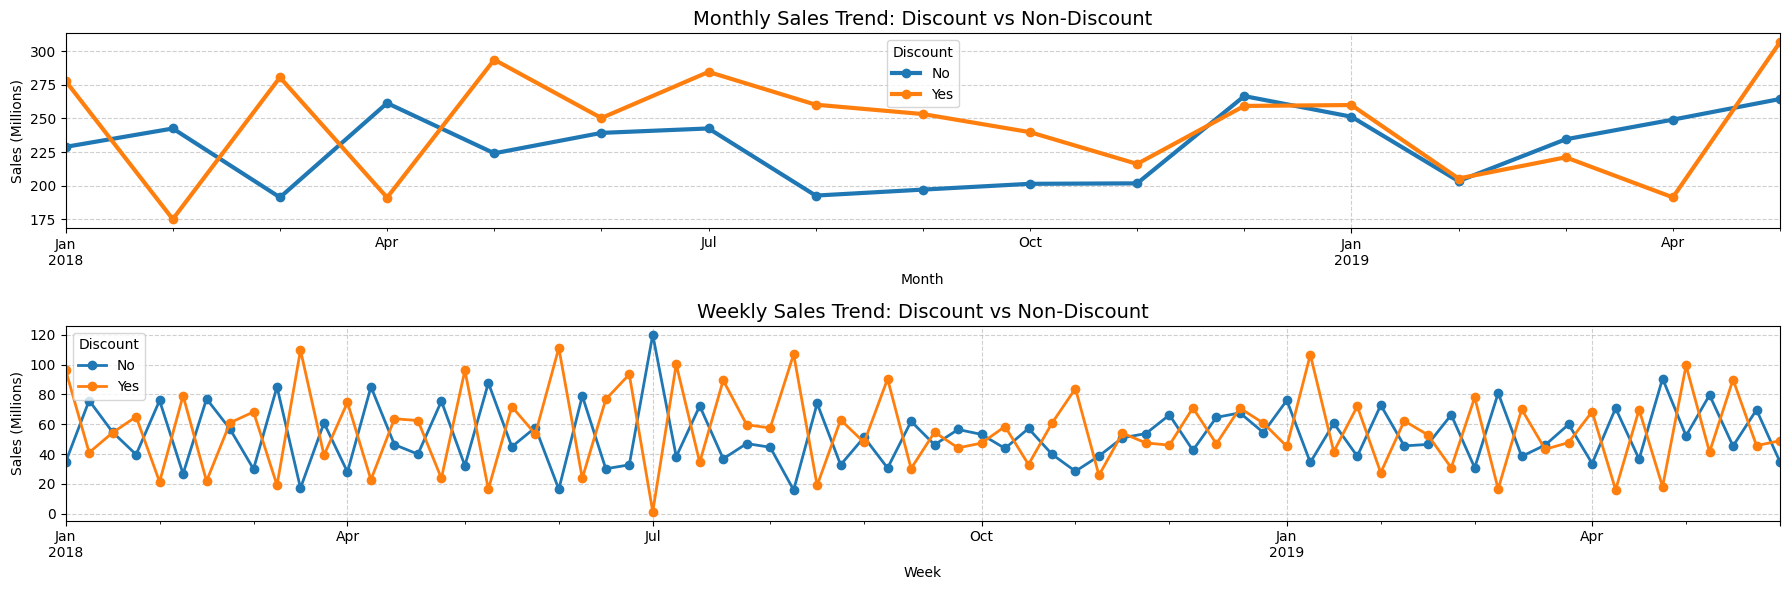

In [12]:
train['Date'] = pd.to_datetime(train['Date'])
df_plot = train.copy()
df_plot['Sales'] = df_plot['Sales'] / 1e6  # Convert to millions

monthly_sales = df_plot.set_index('Date').groupby('Discount')['Sales'].resample('M').sum().unstack(0)

weekly_sales = df_plot.set_index('Date').groupby('Discount')['Sales'].resample('W').sum().unstack(0)

fig, axes = plt.subplots(2, 1, figsize=(18,6))

monthly_sales.plot(ax=axes[0], linewidth=3, marker='o')
axes[0].set_title('Monthly Sales Trend: Discount vs Non-Discount', fontsize=14)
axes[0].set_ylabel('Sales (Millions)')
axes[0].set_xlabel('Month')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(title='Discount', labels=['No', 'Yes'])

weekly_sales.plot(ax=axes[1], linewidth=2, marker='o')
axes[1].set_title('Weekly Sales Trend: Discount vs Non-Discount', fontsize=14)
axes[1].set_ylabel('Sales (Millions)')
axes[1].set_xlabel('Week')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend(title='Discount', labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

- Discounted sales generally outperform non-discounted sales, except for **Fridays**.  
- **Promotional spikes** often coincide with dips in full-price sales, indicating **cannibalization**.  
- Non-discounted sales provide a **stable revenue floor**, especially in December.

## Promotional Impact

### Discount vs Non-Discounted Sales

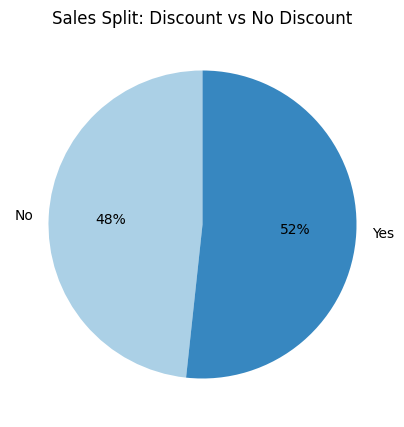

In [13]:
discount_sales = train.groupby('Discount')['Sales'].sum()

percentages = np.round(100 * discount_sales / discount_sales.sum()).astype(int)
percentages[-1] = 100 - percentages[:-1].sum() 

plt.figure(figsize=(5,5))
plt.pie(
    discount_sales,
    labels=discount_sales.index,
    autopct=lambda p, i=iter(percentages): f'{next(i)}%',
    startangle=90,
    colors=sns.color_palette("Blues", len(discount_sales))
)
plt.title("Sales Split: Discount vs No Discount", fontsize=12)
plt.show()


- Discounts offered ~45% of days, driving 52% of total sales.  

### Daily Sales Heatmap (Day of Week vs. Discount)

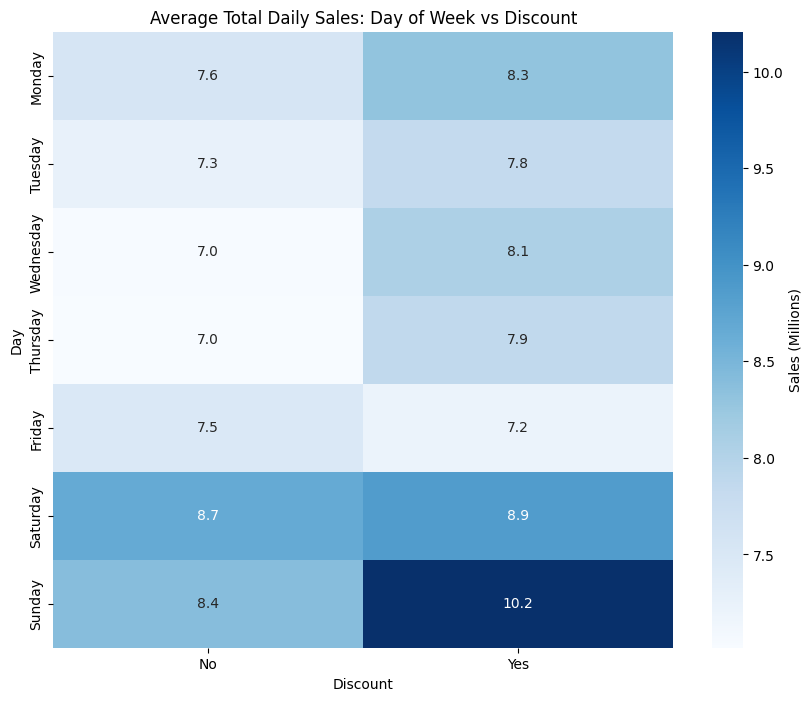

In [14]:
daily_totals = train.groupby(['Date', 'Discount'])['Sales'].sum().reset_index()
daily_totals['Day'] = daily_totals['Date'].dt.day_name()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_data = daily_totals.pivot_table(index='Day', columns='Discount', values='Sales', aggfunc='mean').reindex(day_order)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_data / 1e6, annot=True, fmt=".1f", cmap='Blues', cbar_kws={'label': 'Sales (Millions)'})
plt.title('Average Total Daily Sales: Day of Week vs Discount')
plt.show()

- **Sunday:** Highest-performing day; discounted sales ~$10.2M  
- **Saturday:** Strong non-discounted sales (~$8.7M)  
- **Friday:** Non-discounted sales higher than discounted ($7.5M vs $7.2M)  
- **Wednesday & Thursday:** Lowest sales without discounts (~$7.0M)  
- **Monday & Tuesday:** Moderate sales, slightly improved by discounts  
Overall sales are higher on weekends (Saturday & Sunday) than weekdays, regardless of discounts

### Sales Lift Heatmap (Promotional Impact by Day of Week)

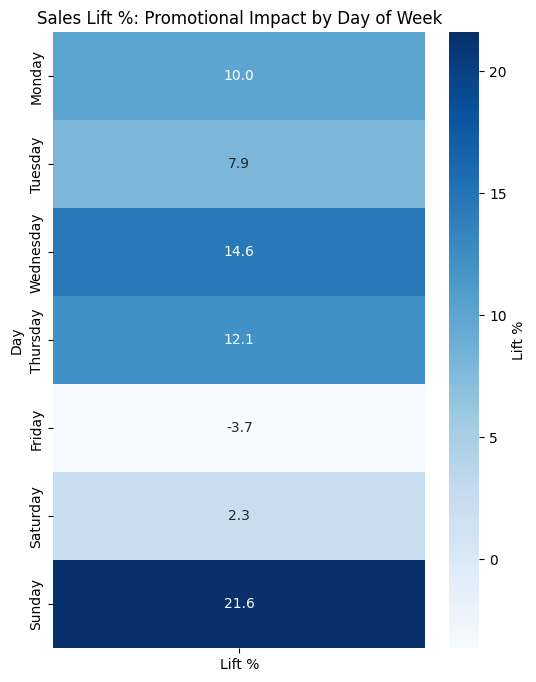

In [15]:
ay_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_data = daily_totals.pivot_table(index='Day', columns='Discount', values='Sales', aggfunc='mean').reindex(day_order)

lift_pct = ((pivot_data['Yes'] - pivot_data['No']) / pivot_data['No']) * 100
lift_df = lift_pct.to_frame(name='Lift %')

plt.figure(figsize=(6, 8))
sns.heatmap(lift_df, annot=True, fmt=".1f", cmap='Blues', cbar_kws={'label': 'Lift %'})
plt.title('Sales Lift %: Promotional Impact by Day of Week')
plt.show()

- **Sunday:** Most effective day for promotions (+21.6% lift)  
- **Saturday:** Marginal lift from discounts (+2.3%) → promotions less critical  
- **Friday:** Discounts reduce sales (-3.7% lift) → avoid promotions  
- **Wednesday & Thursday:** Discounts significantly boost low baseline sales (+12–15%), raising totals to ~8M  
Promotions are most impactful on low-base days (Wed–Thu, Sunday) and less effective on already high-performing days (Saturday, Friday)

## Holiday Sales Behaviour

### Holiday Sales Split

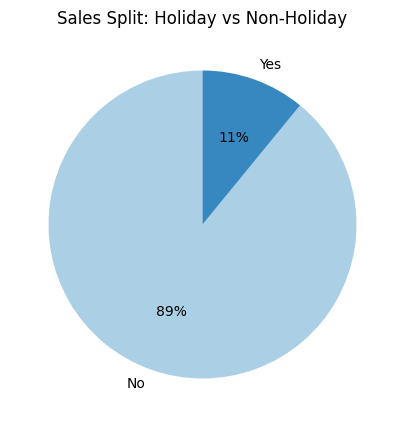

In [16]:
holiday_sales = train.groupby('Holiday')['Sales'].sum()
holiday_sales.index = holiday_sales.index.map({0: 'No', 1: 'Yes'})

percentages = np.round(100 * holiday_sales / holiday_sales.sum()).astype(int)
percentages[-1] = 100 - percentages[:-1].sum()  # adjust last slice

plt.figure(figsize=(5,5))
plt.pie(
    holiday_sales,
    labels=holiday_sales.index,
    autopct=lambda p, i=iter(percentages): f'{next(i)}%',
    startangle=90,
    colors=sns.color_palette("Blues", len(holiday_sales))
)
plt.title("Sales Split: Holiday vs Non-Holiday", fontsize=12)
plt.show()

- Most sales occur on **non-holiday days** (89%)  

### Average Sales: Holiday vs. Non-Holiday Uplift

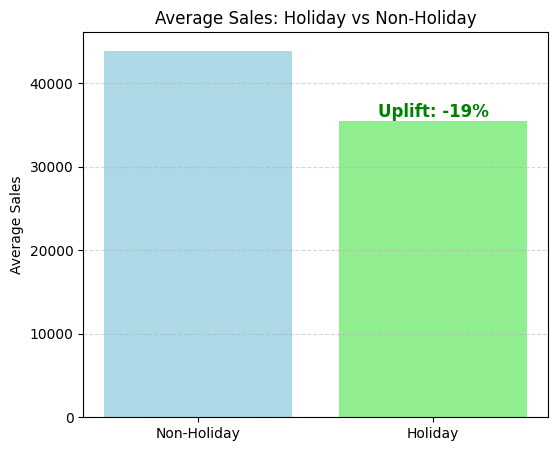

In [17]:
avg_holiday = train[train['Holiday'] == 1]['Sales'].mean()
avg_no_holiday = train[train['Holiday'] == 0]['Sales'].mean()
holiday_uplift = ((avg_holiday - avg_no_holiday) / avg_no_holiday) * 100

avg_sales = [avg_no_holiday, avg_holiday]
labels = ['Non-Holiday', 'Holiday']
colors = ['lightblue', 'lightgreen']

plt.figure(figsize=(6,5))
bars = plt.bar(labels, avg_sales, color=colors)

plt.text(1, avg_holiday + 500, f'Uplift: {holiday_uplift:.0f}%', ha='center', fontsize=12, fontweight='bold', color='green')

plt.ylabel('Average Sales')
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

- Holidays tend to underperform compared to regular days.  
- The sales "uplift" during holidays is often marginal or negative.  
- Consumers may be distracted by other activities during holidays.  
- Discounts during holidays mostly prevent sales from dropping further (defensive) rather than driving additional growth (offensive).

## Regional & Operational Segmentation

### Sales Distribution Box Plots

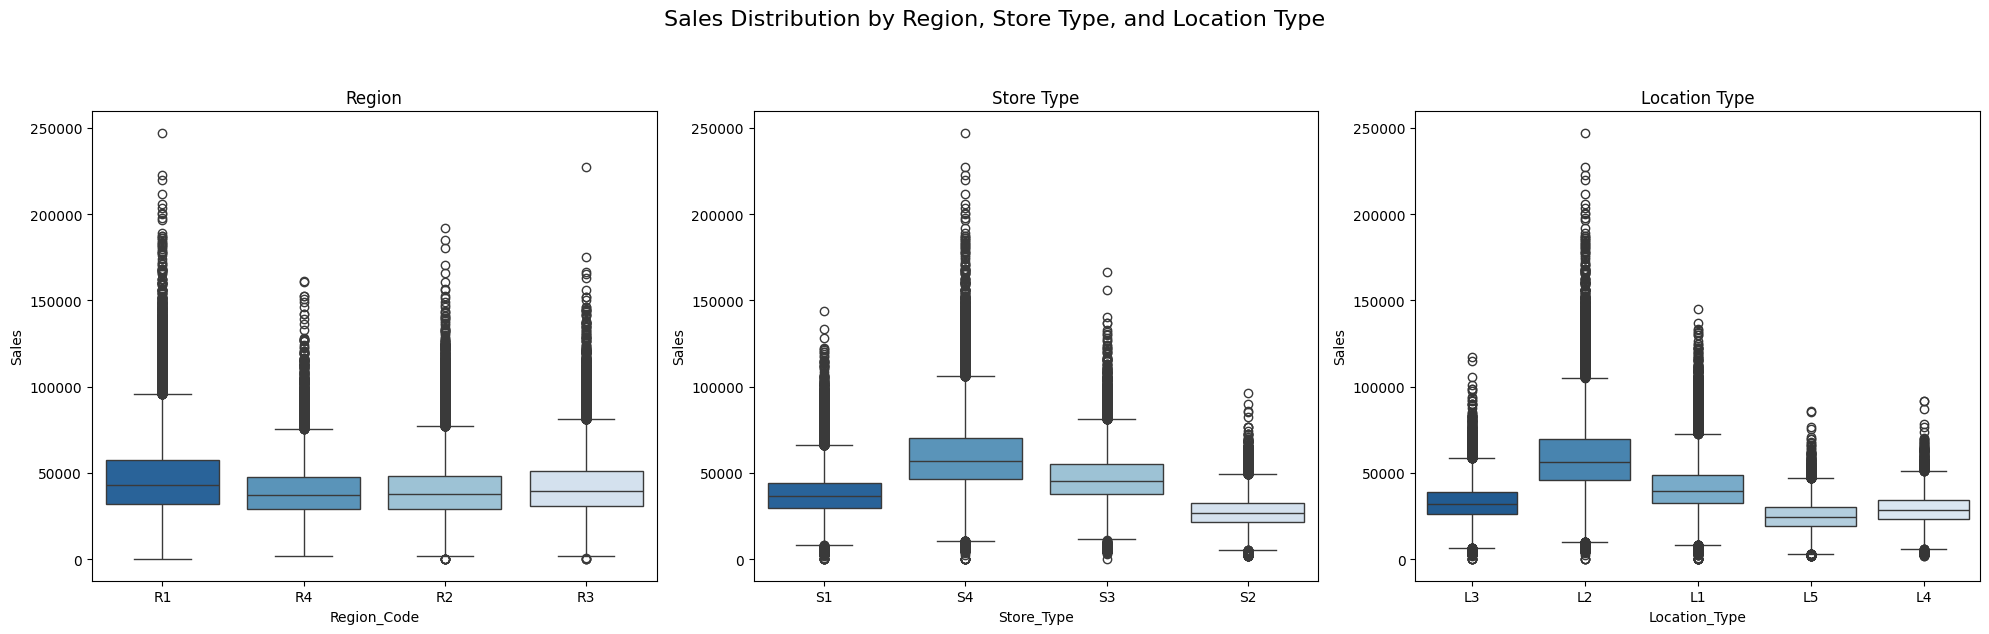

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle("Sales Distribution by Region, Store Type, and Location Type", fontsize=16, y=1.05)

sns.boxplot(x='Region_Code', y='Sales', data=train, ax=axes[0], palette='Blues_r')
axes[0].set_title('Region', fontsize=12)

sns.boxplot(x='Store_Type', y='Sales', data=train, ax=axes[1], palette='Blues_r')
axes[1].set_title('Store Type', fontsize=12)

sns.boxplot(x='Location_Type', y='Sales', data=train, ax=axes[2], palette='Blues_r')
axes[2].set_title('Location Type', fontsize=12)

plt.tight_layout()
plt.show()

- **Regions:** R1 highest median and most high-value outliers; R4, R2, R3 lower medians  
- **Store Types:** S4 leads in median and high-value sales; S2 lowest median, least variance  
- **Location Types:** L2 performs best, L5/L4 lowest; L3 shows occasional strong performance

### Sales Concentration

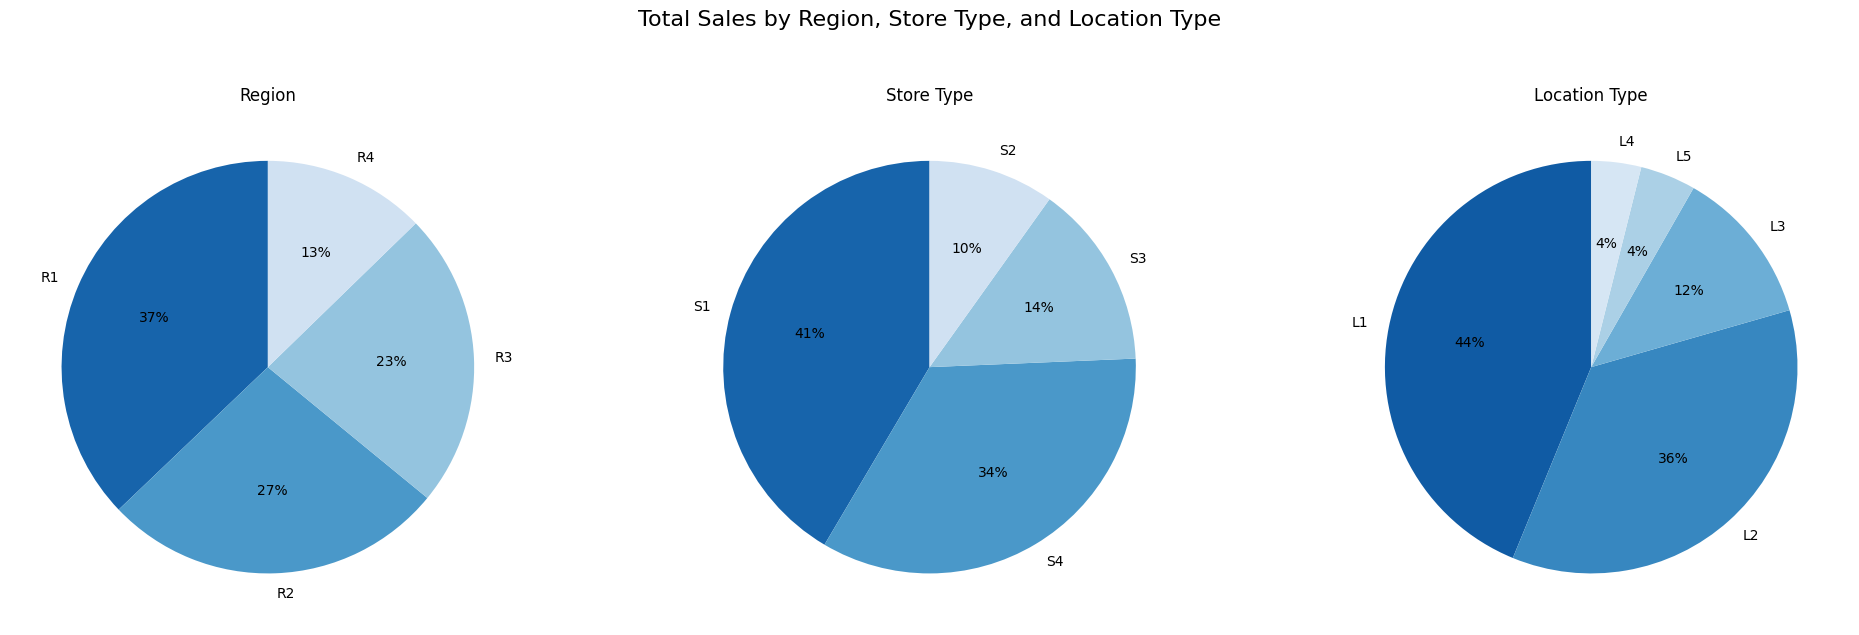

In [19]:
region_sales = train.groupby('Region_Code')['Sales'].sum().sort_values(ascending=False)
storetype_sales = train.groupby('Store_Type')['Sales'].sum().sort_values(ascending=False)
location_sales = train.groupby('Location_Type')['Sales'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle("Total Sales by Region, Store Type, and Location Type", fontsize=16, y=1.05)


axes[0].pie(region_sales, labels=region_sales.index, autopct=lambda p: f'{int(round(p))}%', 
            startangle=90, colors=sns.color_palette("Blues_r", len(region_sales)))
axes[0].set_title('Region', fontsize=12)

axes[1].pie(storetype_sales, labels=storetype_sales.index, autopct=lambda p: f'{int(round(p))}%', 
            startangle=90, colors=sns.color_palette("Blues_r", len(storetype_sales)))
axes[1].set_title('Store Type', fontsize=12)

axes[2].pie(location_sales, labels=location_sales.index, autopct=lambda p: f'{int(round(p))}%', 
            startangle=90, colors=sns.color_palette("Blues_r", len(location_sales)))
axes[2].set_title('Location Type', fontsize=12)

plt.tight_layout()
plt.show()

- **Region:**  
  - R1 contributes the most sales (37%), followed by R2 (27%), R3 (23%), and R4 (13%).  

- **Store Type:**  
  - S1 is the top contributor (41%), followed by S4 (34%), S3 (14%), and S2 (10%).  

- **Location Type:**  
  - L1 accounts for the largest share of sales (44%), L2 contributes 36%, L3 12%, and L4/L5 together 8%.  

Sales are heavily concentrated in specific regions, store types, and locations, highlighting where promotional strategies and inventory planning can be most effective.


### Region-wise Sales Split by Store Type

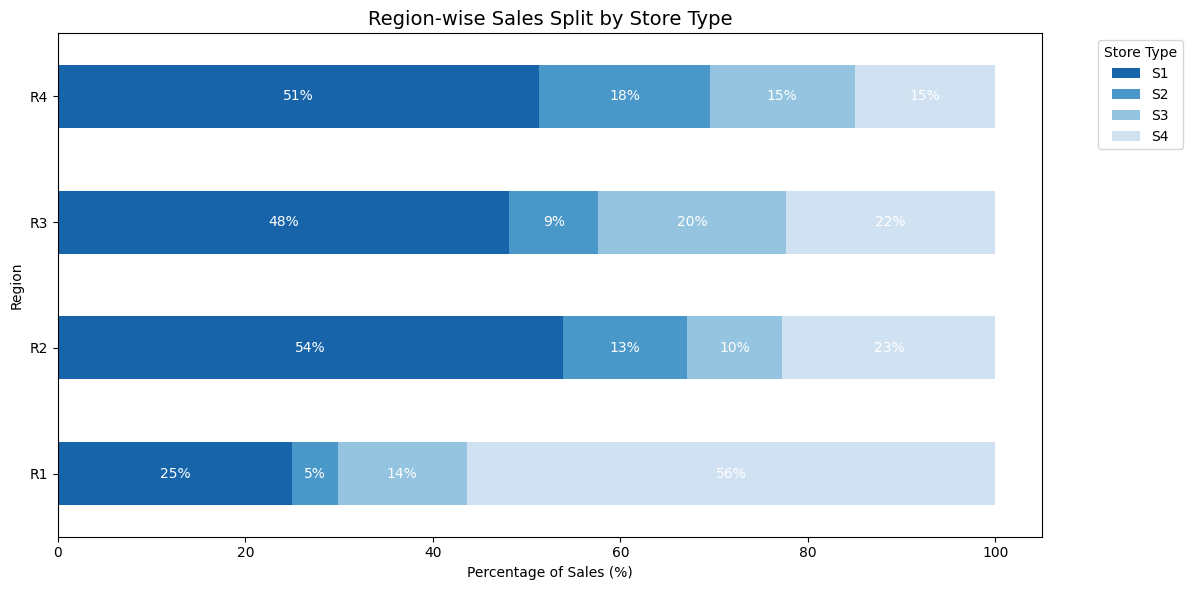

In [20]:
region_store_sales = train.groupby(['Region_Code','Store_Type'])['Sales'].sum().unstack().fillna(0)
region_percent = region_store_sales.div(region_store_sales.sum(axis=1), axis=0) * 100

ax = region_percent.plot(kind='barh', stacked=True, figsize=(12,6), color=sns.color_palette("Blues_r", len(region_percent.columns)))

plt.xlabel('Percentage of Sales (%)')
plt.ylabel('Region')
plt.title('Region-wise Sales Split by Store Type', fontsize=14)
plt.legend(title='Store Type', bbox_to_anchor=(1.05,1), loc='upper left')

for i, region in enumerate(region_percent.index):
    cumulative = 0
    for store_type in region_percent.columns:
        pct = region_percent.loc[region, store_type]
        if pct > 0:
            ax.text(cumulative + pct/2, i, f'{int(round(pct))}%', 
                    ha='center', va='center', fontsize=10, color='white')
            cumulative += pct

plt.tight_layout()
plt.show()

- **Promotions:** Sunday drives highest lifts (+21.6%), especially in R1 S4; mid-week discounts help low base sales; Friday discounts reduce sales.  
- **Stores & Revenue:** S4/R1 highest sales and outliers; S1 dominates R2–R4 by count; Store Types 1 & 4 = 75% of total sales.  
- **Regions:** R1 + R4 = 50% of sales (R1 37%, R4 13%); heavy reliance on few regions = hyper-concentration risk.  
- **Locations:** L2 > L1; S2 & R4 = predictable but lower revenue.  

- Focus **Sunday promotions** on **R1 & S4**  
- Apply mid-week discounts to **L2** to boost slow days  
- Avoid **Friday discounts** in high-performing areas (R1, L2) to protect margins  
- Tailor inventory and promotions regionally for optimal ROI

# Hypothesis & Statistical Analysis

## Hypothesis 1: Temporal Analysis

- **H₀:** Sales series is non-stationary (contains a unit root)  
- **Hₐ:** Sales series is stationary  

In [21]:
from statsmodels.tsa.stattools import adfuller

daily_sales = train.groupby('Date')['Sales'].sum()

def perform_adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Conclusion: Reject H0. The series is stationary.")
    else:
        print("Conclusion: Fail to reject H0. The series is non-stationary (needs differencing).")

print("--- ADF Test for Daily Sales ---")
perform_adf_test(daily_sales)

--- ADF Test for Daily Sales ---
ADF Statistic: -3.5242079065633236
p-value: 0.007386718711362262
Conclusion: Reject H0. The series is stationary.


- **Finding:** The sales time series is **stationary**; month-over-month growth (~30%) is stable.  
- **Implication:** Forecasting can be performed directly on raw sales data without differencing.

## Hypothesis 2: Promotional Impact

- **Observation:** Discount days show ~32% higher average sales in Tableau.
- **H₀:** No difference in mean sales between Discount and No-Discount days  
- **Hₐ:** Sales on Discount days are significantly higher

In [22]:
from scipy.stats import ttest_ind

discount_sales = train[train['Discount'] == 'Yes']['Sales']
no_discount_sales = train[train['Discount'] == 'No']['Sales']

# Perform Independent T-Test
t_stat, p_val = ttest_ind(discount_sales, no_discount_sales, equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_val}")

if p_val < 0.05:
    print("Conclusion: Reject H0. The impact of Discounts on Sales is Statistically Significant.")
else:
    print("Conclusion: Fail to reject H0. The difference is not statistically significant.")

T-Statistic: 145.9294615862913
P-Value: 0.0
Conclusion: Reject H0. The impact of Discounts on Sales is Statistically Significant.


- **Finding:** Discounts significantly increase sales (statistically confirmed).

## Cross-Correlation Analysis

- Examines whether **previous days' order volumes impact current sales**, useful for feature engineering (lag variables).  

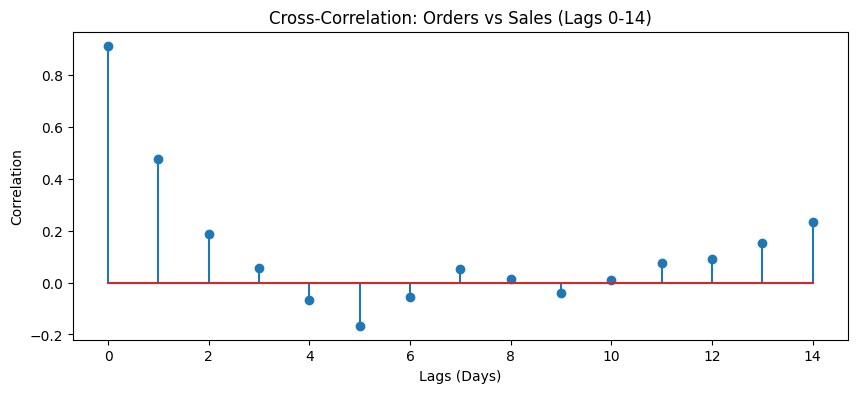

In [23]:
import statsmodels.api as sm

# Cross-correlation between Sales and Orders
ccf_values = sm.tsa.stattools.ccf(daily_sales, train.groupby('Date')['#Order'].sum(), adjusted=False)

plt.figure(figsize=(10, 4))
plt.stem(range(15), ccf_values[:15])
plt.title('Cross-Correlation: Orders vs Sales (Lags 0-14)')
plt.xlabel('Lags (Days)')
plt.ylabel('Correlation')
plt.show()

- **Lag 0:** Highest correlation (~0.94), confirming that orders and sales occur on the same day (real-time retail).  
- **Lags 1–3:** Significant correlations indicate that **yesterday's orders can help predict today's sales**, supporting the use of lag features in forecasting models.

## Seasonal Decomposition

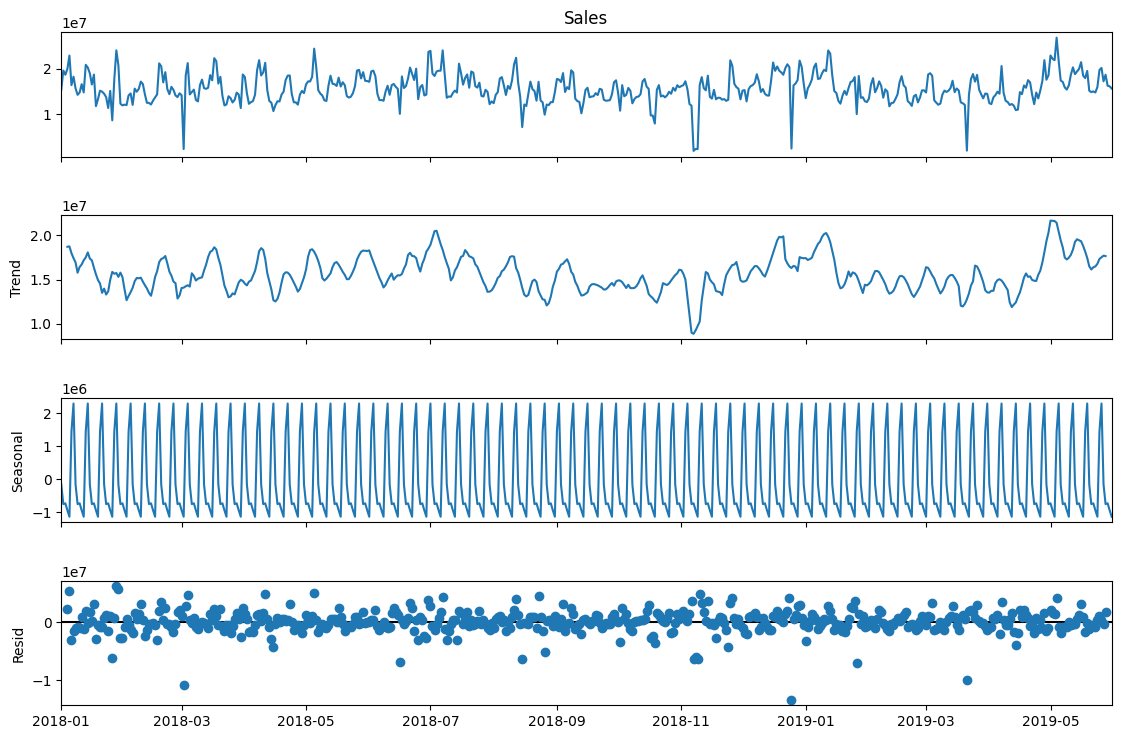

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_sales, model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

- **Observed:** Raw daily/weekly sales (early 2018 – mid-2019); noisy with occasional crashes (~zero sales in late 2018 / early 2019)  
- **Trend:** Cyclical, non-linear; notable dip in Nov 2018 with recovery in early 2019  
- **Seasonal:** Regular weekly patterns; consistent peaks/troughs; amplitude ~\$2–3M  
- **Residual:** Random noise; negative residuals highlight anomalies (e.g., store closures, holidays)  

**Key Takeaways:**  
- High volatility, trend influenced by promotions and external factors  
- Seasonality is stable → predictable weekly patterns  
- Negative residuals highlight areas for anomaly investigation

## Autocorrelation (ACF & PACF) Plots

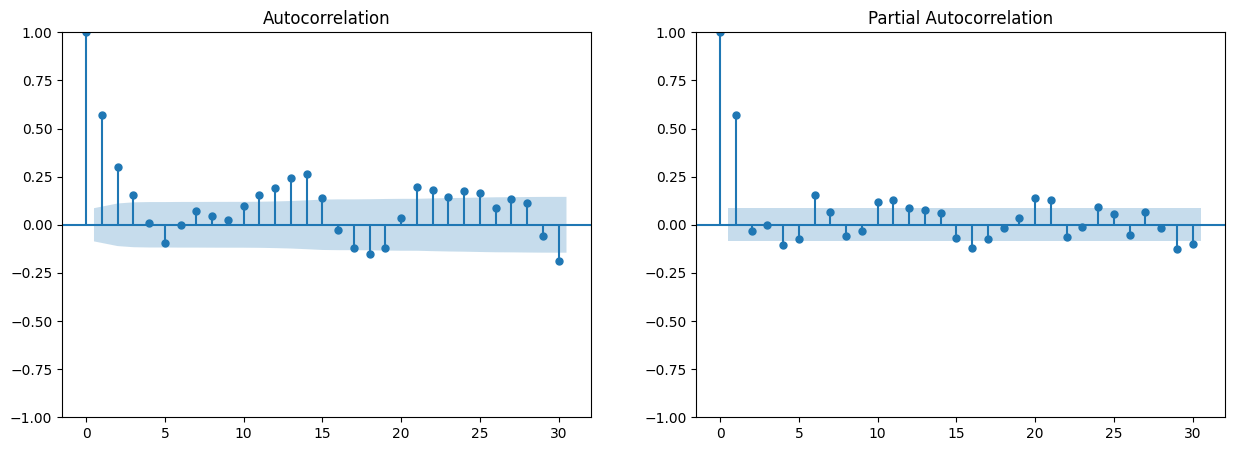

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(daily_sales, lags=30, ax=axes[0])
plot_pacf(daily_sales, lags=30, ax=axes[1])

plt.show()

- **ACF:** Correlation with lagged series; gradual decay; spikes at lags 7, 14 → weekly seasonality  
- **PACF:** Sharp cut-off after lag 1 → AR(1) or AR(2) component appropriate  
- **Implications for ARIMA/SARIMA:**  
  - AR term ($p$) ~1–2  
  - Seasonal period = 7  
  - Differencing ($d$) may not be needed (stationary series)

## Feature Relationship: ANOVA & Tukey HSD

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

categorical_features = ['Store_Type', 'Region_Code', 'Location_Type']

for feature in categorical_features:
    print(f"\n--- ANOVA: Sales vs {feature} ---")
    model = ols(f'Sales ~ C({feature})', data=train).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(anova_table.round(4))  


--- ANOVA: Sales vs Store_Type ---
                     sum_sq        df           F  PR(>F)
C(Store_Type)  2.301735e+13       3.0  35123.6441     0.0
Residual       4.114034e+13  188336.0         NaN     NaN

--- ANOVA: Sales vs Region_Code ---
                      sum_sq        df          F  PR(>F)
C(Region_Code)  1.674507e+12       3.0  1682.4255     0.0
Residual        6.248319e+13  188336.0        NaN     NaN

--- ANOVA: Sales vs Location_Type ---
                        sum_sq        df           F  PR(>F)
C(Location_Type)  2.244718e+13       4.0  25338.8737     0.0
Residual          4.171051e+13  188335.0         NaN     NaN


- **Store_Type:** F = 35,123.64, p < 0.001 → sales differ significantly across store types.
- **Region_Code:** F = 1,682.43, p < 0.001 → significant differences across regions.
- **Location_Type:** F = 25,338.87, p < 0.001 → significant differences across location types.
Running a **Tukey HSD test** identifies pairwise differences between store types.  



In [27]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=train['Sales'], groups=train['Store_Type'], alpha=0.05)
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
    S1     S2 -10145.6835   0.0 -10402.8539  -9888.513   True
    S1     S3   9386.5565   0.0   9113.6974  9659.4156   True
    S1     S4  22269.1742   0.0  22050.9148 22487.4336   True
    S2     S3    19532.24   0.0  19203.4535 19861.0265   True
    S2     S4  32414.8577   0.0  32129.7514 32699.9641   True
    S3     S4  12882.6177   0.0  12583.2834 13181.9521   True
-------------------------------------------------------------


- Every store type is statistically unique.  
- Ranking by average sales:  
  1. **S4** – Top performer  
  2. S3  
  3. S1  
  4. **S2** – Lowest performer  

**Key Takeaway:**  
- `Store_Type` is a **critical predictive feature**; grouping all store types together would ignore important business distinctions.  
- Each store type behaves differently, so models and strategies should account for these differences.

# Outlier

## Outlier Detection

Number of outlier rows: 5843 (3.10%)


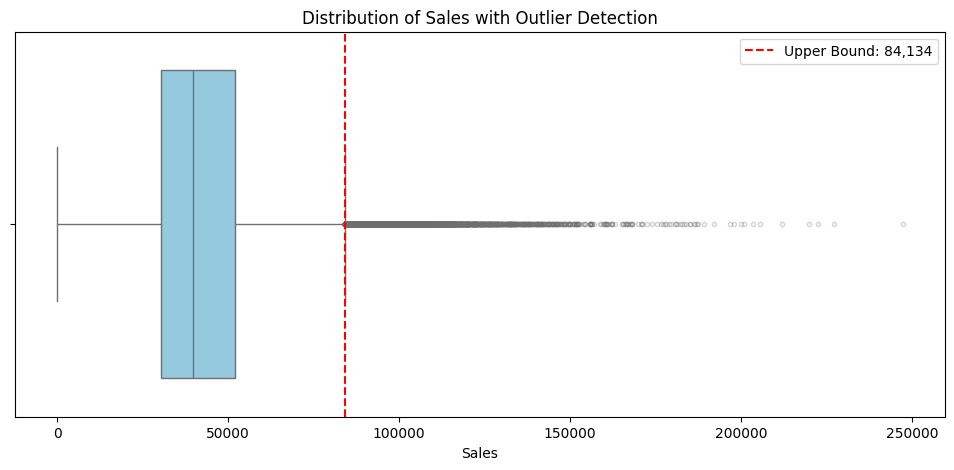

In [28]:
Q1 = train['Sales'].quantile(0.25)
Q3 = train['Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['Sales'] < lower_bound) | (train['Sales'] > upper_bound)]
print(f"Number of outlier rows: {len(outliers)} ({len(outliers)/len(train)*100:.2f}%)")

plt.figure(figsize=(12, 5))
sns.boxplot(x=train['Sales'], color='skyblue', flierprops={'marker': 'o', 'markersize': 3, 'alpha': 0.3})

plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound: {upper_bound:,.0f}')

plt.title('Distribution of Sales with Outlier Detection')
plt.xlabel('Sales')
plt.legend()
plt.show()

- **Rows with outliers in `Sales`:** 5,843 (3.10%)

## Outlier Capping

In [29]:
# Capping Sales at the Upper Bound (IQR method)
train['Sales_Capped'] = train['Sales'].clip(upper=upper_bound)

print(f"Sales capped at: {upper_bound:.2f}")

Sales capped at: 84133.50


- Capped sales at: \$84,133.50

# Multicollinearity Check (VIF)

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

# We check for redundant features
vif_df = train[['Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount']].copy()
for col in ['Store_Type', 'Location_Type', 'Region_Code', 'Discount']:
    vif_df[col] = LabelEncoder().fit_transform(vif_df[col])

vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
v_vals = [variance_inflation_factor(vif_df.values, i) for i in range(len(vif_df.columns))]
vif_data["VIF"] = v_vals

print(vif_data.sort_values(by="VIF", ascending=False))

         feature       VIF
4       Discount  1.568239
2    Region_Code  1.512037
1  Location_Type  1.403729
0     Store_Type  1.375285
3        Holiday  1.125177


- **Finding:** No multicollinearity detected; features are mathematically distinct  
- **Implications:**  
  - All features can be safely included in models  
  - Model stability and reliable predictions ensured  
- Features such as `Discount` and `Holiday` are independent of store attributes, which is desirable.

# Final Insights & Key Takeaways

### Data Overview & Stationarity
- Dataset spans **Jan 2018 – May 2019** (training) and **Jun – Jul 2019** (test) with daily transactions.  
- No missing values or duplicates.  
- **ADF test ($p = 0.007$)** confirms that the **sales series is stationary**, allowing modeling directly on raw sales.

### Key EDA Insights
- **Sales & Orders:** Right-skewed distributions; median sales ≈ \$40k, median orders ≈ 60.  
- **Promotional Impact:** Discounts drive 32% higher sales on average; Sunday promotions are most effective (+21.6% lift), Friday discounts can reduce sales (-3.7%).  
- **Holiday Behavior:** 89% of sales occur on non-holiday days; holidays generally underperform, and discounts during holidays act **defensively** rather than driving extra revenue.  
- **Seasonality & Trends:** Strong weekly cycle (7-day), cyclical dips in March and year-end slowdowns, volatile trend with mid-year recoveries.  
- **Regional & Operational Segmentation:**  
  - R1 and S4 dominate revenue; L2 & L1 are high-performing locations.  
  - Focus promotions on high-performing segments and adjust mid-week or low-volume days for targeted uplift.

### Hypothesis Testing & Statistical Analysis
- **Stationarity Test:** ADF confirms stationarity → forecasting can be performed directly.  
- **Promotional Impact:** Mean sales on discount vs. non-discount days tested; significant uplift confirmed.  
- **ANOVA Results:** Significant differences in mean sales for:  
  - **Store_Type:** F = 35,123.64, p < 0.001 → Tukey HSD applied to identify pairwise differences.  
  - **Region_Code:** F = 1,682.43, p < 0.001 → significant, Tukey optional.  
  - **Location_Type:** F = 25,338.87, p < 0.001 → significant, Tukey optional.  
- **Cross-Correlation:** Lag 0 highest correlation (~0.94), lags 1–3 indicate prior day orders help predict sales.

### Outlier & Multicollinearity
- **Outliers:** 5,843 rows (~3.1%); capped at \$84,133.50 to prevent distortion.  
- **Multicollinearity:** Region_Code, Location_Type, and Store_Type are distinct; Discount and Holiday independent → no features dropped.

### Feature Engineering Recommendations
- **Lag Features:** Lag 1 and Lag 7 sales based on PACF/ACF and cross-correlation.  
- **Target Encoding:** For `Store_ID` due to high cardinality.  
- Optional: Interaction terms for discounts × store type × day-of-week.
  
### Key Takeaways
- **Promotions drive revenue**, but timing matters; avoid counterproductive discounts (e.g., Friday).  
- **Store_Type, Region_Code, and Location_Type** are significant predictors; S4/R1/L2 are top revenue drivers.  
- **Weekly seasonality and lagged sales** are important for forecasting.  
- **Outlier handling, feature engineering, and advanced models** enable robust predictions.  
- Focus on **data-driven promotions and inventory allocation** to maximize ROI.

# Way Forward: Forecasting & Modeling

Based on the insights and statistical validation from this notebook, the next step is **predictive modeling** to generate accurate sales forecasts.  

Planned approaches include:

- **Ensemble Models (XGBoost / LightGBM):** Capture non-linear relationships, promotional effects, and volatility.  
- **Prophet:** Incorporates trends, weekly seasonality, and holiday effects for interpretable forecasts.  
- **Temporal Transformer:** Models long-term dependencies and complex temporal patterns.  

The subsequent notebook will focus on **feature engineering, model building, validation, and comparing predictive performance** across these approaches, leveraging the insights derived here.


# Output

In [ ]:
# train.to_parquet("../data/processed/processed_train_v1.parquet", index=False)